# 1. import essential packages

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# 2. construct graph

In [4]:
# import data
graph_data = pd.read_csv('/home/ouconstand/Learning/drug_disease/download/data/therapeutic_drug_diseases.csv')[['ChemicalName','DiseaseName']]

In [5]:
# construct graph
G = nx.DiGraph()
n = 0
labels = {}
for chemical, disease in zip(graph_data['ChemicalName'],graph_data['DiseaseName']):
    G.add_edge(chemical, disease)
    labels[chemical] = 'chemical'
    labels[disease] = 'disease'
    n += 1
    if n == 200:
        break


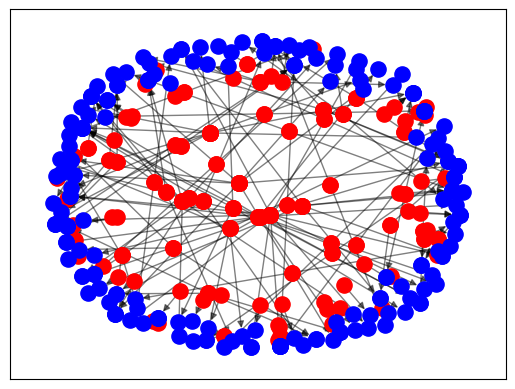

In [6]:
pos = nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, nodelist=list(graph_data['ChemicalName'])[:200], node_color='red', node_size= 120)
nx.draw_networkx_nodes(G, pos, nodelist=list(graph_data['DiseaseName'])[:200], node_color='blue', node_size= 120)

# edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, node_size=120)

# 3. construct a neural network

In [7]:
from deepsnap.graph import Graph
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv 
from torch_geometric.utils import train_test_split_edges

/home/ouconstand/software/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# the graph class of networkx is converted to data class of torch_geometric
data = Graph(G)
data.num_features = 1 # I don't know what's this meaning
data.matrix = torch.ones((data.num_nodes, data.num_features), dtype=torch.float32)
data.edge_attr = None
data = train_test_split_edges(data)

/home/ouconstand/software/anaconda3/envs/pytorch/lib/python3.7/site-packages/deepsnap/graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")
/home/ouconstand/software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.matrix, data.train_pos_edge_index)
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [11]:
def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
        force_undirected=True,
    )
    optimizer.zero_grad()
    z = model.encode()
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        z = model.encode()
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return perfs

In [13]:
best_val_perf = test_perf = 0
for epoch in range(1, 11):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_loss, best_val_perf, test_perf))

z = model.encode()
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.7318, Val: 0.8333, Test: 0.7708
Epoch: 002, Loss: 0.6916, Val: 0.8333, Test: 0.7708
Epoch: 003, Loss: 0.6973, Val: 0.8333, Test: 0.7708
Epoch: 004, Loss: 0.6995, Val: 0.8333, Test: 0.7708
Epoch: 005, Loss: 0.6961, Val: 0.8333, Test: 0.7708
Epoch: 006, Loss: 0.6939, Val: 0.8333, Test: 0.7708
Epoch: 007, Loss: 0.6934, Val: 0.8333, Test: 0.7708
Epoch: 008, Loss: 0.6931, Val: 0.8333, Test: 0.7708
Epoch: 009, Loss: 0.6928, Val: 0.8333, Test: 0.7708
Epoch: 010, Loss: 0.6926, Val: 0.8333, Test: 0.7708
